In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pyproj import Proj, transform
import contextily as ctx
from shapely.geometry import box
import fiona

# Documentation for how to use data here: https://www.pge.com/b2b/distribution-resource-planning/downloads/integration-capacity/PGE_ICA_Map_User_Guide.pdf
gdb_path = "../../../data/raw/iou_pge/ICADisplay.gdb"

# List all layers
layers = fiona.listlayers(gdb_path)


### Read in and cache ICA files

In [5]:
feeder = gpd.read_file("../../../data/raw/iou_pge/ICADisplay.gdb", driver='fileGDB', layer="FeederDetail")
ica_estimated_capacity = gpd.read_file("../../../data/raw/iou_pge/ICADisplay.gdb", driver='fileGDB', layer="ICAEstimatedCapacitySummary")

In [6]:
ica_estimated_capacity.head()

,feederid,globalid,CSV_LineSection,LoadICA,ForecastFeederHeadroom,ForecastBankHeadroom,LoadApplications,PlannedProjects,FreeTransfers,ExpectedCapacity,geometry
0,083671106,{0310BD68-DF8F-4AA0-BEB1-5B2D89C25DDB},3171826,Yes,Yes,No,No,No,No,No Expected Capacity,None
1,083671106,{04FA3413-AF06-4A92-B766-6D6A192488AB},5004936,Yes,Yes,No,No,No,No,No Expected Capacity,None
2,152581104,{00E9C128-ED92-485C-BE8E-244E60D6F55E},3992567,Yes,Yes,Yes,No,No,Yes,Engineering Assessment Required,None
3,083671106,{0CBA77CF-7736-4258-8698-5C9CF67404B6},3181486,Yes,Yes,No,No,No,No,No Expected Capacity,None
4,152581104,{0E0B9F85-7648-4D69-8E60-DC7E2BCC9952},4083224,Yes,Yes,Yes,No,No,Yes,Engineering Assessment Required,None


#### Count Feeders
Calculate the number of unique feeders that have "No Expected Capacity" = 901

In [7]:
no_expected_capacity_feeders = ica_estimated_capacity[ica_estimated_capacity['ExpectedCapacity'] == "No Expected Capacity"]
print(len(no_expected_capacity_feeders['feederid'].unique()))
no_expected_capacity_feeders.head()

901


,feederid,globalid,CSV_LineSection,LoadICA,ForecastFeederHeadroom,ForecastBankHeadroom,LoadApplications,PlannedProjects,FreeTransfers,ExpectedCapacity,geometry
0,083671106,{0310BD68-DF8F-4AA0-BEB1-5B2D89C25DDB},3171826,Yes,Yes,No,No,No,No,No Expected Capacity,None
1,083671106,{04FA3413-AF06-4A92-B766-6D6A192488AB},5004936,Yes,Yes,No,No,No,No,No Expected Capacity,None
3,083671106,{0CBA77CF-7736-4258-8698-5C9CF67404B6},3181486,Yes,Yes,No,No,No,No,No Expected Capacity,None
6,083671106,{08459293-F8FD-49AA-80F0-25F808E1923F},3167315,Yes,Yes,No,No,No,No,No Expected Capacity,None
7,083192102,{0079B0D4-6635-41CA-873C-21AE0C1A8535},3739192,Yes,Yes,No,No,No,No,No Expected Capacity,None


In [8]:
# Merge no_expected_capacity_feeders with feeder geometries using the 'feederid' column from no_expected_capacity_feeders and 'FeederID' from feeder
no_capacity_feeders = no_expected_capacity_feeders[['feederid']].drop_duplicates().merge(
    feeder[['FeederID', 'geometry']], 
    left_on='feederid', 
    right_on='FeederID', 
    how='left'
)

print(len(no_capacity_feeders))


no_capacity_feeders.to_csv('no_capacity_feeders.csv', index=False)

901


In [9]:
no_capacity_feeders.head()

,feederid,FeederID,geometry
0,083671106,083671106,"MULTILINESTRING ((587911.275 4133626.053, 5879..."
1,083192102,083192102,"MULTILINESTRING ((608409.675 4083552.913, 6084..."
2,082021108,082021108,"MULTILINESTRING ((590501.525 4120638.533, 5905..."
3,182331101,182331101,"MULTILINESTRING ((623731.275 4069263.513, 6237..."
4,042281105,042281105,"MULTILINESTRING ((490165.745 4350902.753, 4901..."


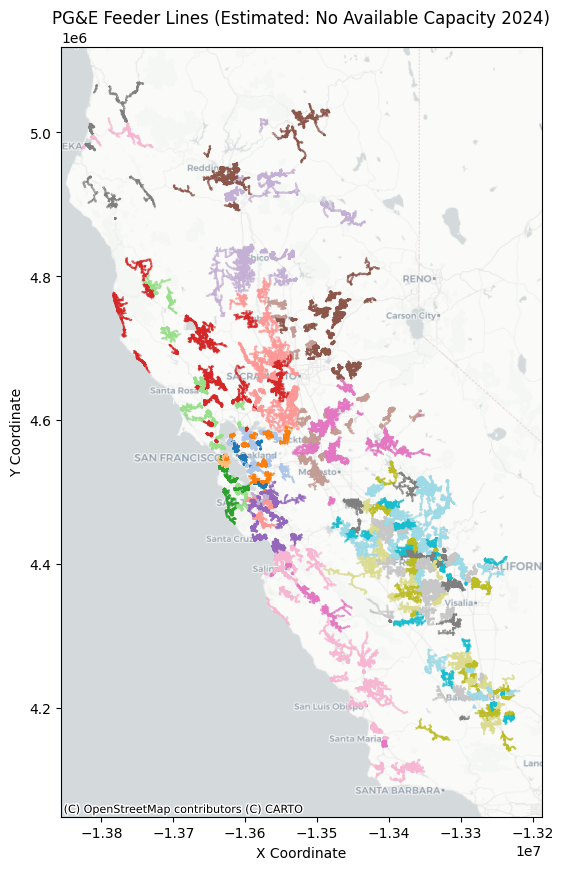

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(no_capacity_feeders, geometry='geometry')

# Set the GeoDataFrame to the same CRS as the basemap (Web Mercator)
gdf = gdf.to_crs(epsg=3857)

# Plot the GeoDataFrame with each feeder in a separate color
ax = gdf.plot(column='feederid', legend=False, cmap='tab20', figsize=(10, 10), alpha=0.8)

# Add a basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title('PG&E Feeder Lines (Estimated: No Available Capacity 2024)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

#### Engineering assessment needed for capacity # of feeders = 

In [11]:
eng_assessment_capacity_feeders = ica_estimated_capacity[ica_estimated_capacity['ExpectedCapacity'] == "Engineering Assessment Required"]
print(len(eng_assessment_capacity_feeders['feederid'].unique()))
# eng_assessment_capacity_feeders.head()

952


#### Likely to have capacity # of feeders = 1319

In [12]:
likely_have_capacity_feeders = ica_estimated_capacity[ica_estimated_capacity['ExpectedCapacity'] == "Likely to Have Available Capacity"]
print(len(likely_have_capacity_feeders['feederid'].unique()))
# likely_have_capacity_feeders.head()

# Merge no_expected_capacity_feeders with feeder geometries using the 'feederid' column from no_expected_capacity_feeders and 'FeederID' from feeder
likely_have_capacity_feeders = likely_have_capacity_feeders[['feederid']].drop_duplicates().merge(
    feeder[['FeederID', 'geometry']], 
    left_on='feederid', 
    right_on='FeederID', 
    how='left'
)

1319


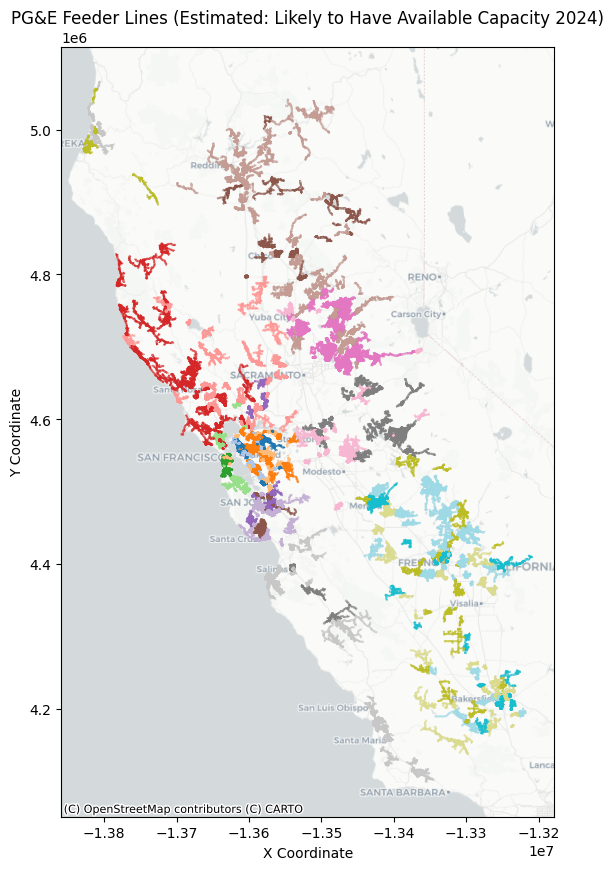

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Convert to a GeoDataFrame
has_capacity_gdf = gpd.GeoDataFrame(likely_have_capacity_feeders, geometry='geometry')

# Set the GeoDataFrame to the same CRS as the basemap (Web Mercator)
has_capacity_gdf = has_capacity_gdf.to_crs(epsg=3857)

# Plot the GeoDataFrame with each feeder in a separate color
ax = has_capacity_gdf.plot(column='feederid', legend=False, cmap='tab20', figsize=(10, 10), alpha=0.8)

# Add a basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title('PG&E Feeder Lines (Estimated: Likely to Have Available Capacity 2024)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## Render as GeoJSON

In [16]:
import geopandas as gpd
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

gdf = gpd.GeoDataFrame(no_capacity_feeders, geometry='geometry')

# Reproject GeoDataFrame to EPSG:4326 for Folium
gdf = gdf.to_crs(epsg=4326)

# Centroid of the GeoDataFrame for map centering
map_center = [
    gdf.geometry.centroid.y.mean(), 
    gdf.geometry.centroid.x.mean()
]

m = folium.Map(location=map_center, zoom_start=10)

# Create a colormap with enough colors for all feeders
feeder_ids = gdf['feederid'].unique()
colormap = cm.get_cmap('tab20', len(feeder_ids))

# Map feeder IDs to colors
feeder_color_mapping = {}
for idx, feeder_id in enumerate(feeder_ids):
    rgba_color = colormap(idx)
    hex_color = colors.rgb2hex(rgba_color)
    feeder_color_mapping[feeder_id] = hex_color

def style_function(feature):
    feeder_id = feature['properties']['feederid']
    return {
        'fillColor': feeder_color_mapping.get(feeder_id, 'black'),
        'color': feeder_color_mapping.get(feeder_id, 'black'),
        'weight': 2,
        'fillOpacity': 0.6,
    }

folium.TileLayer('openstreetmap').add_to(m)

folium.GeoJson(
    gdf,
    name='Low Capacity Circuits',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['feederid'],
        aliases=['Feeder ID:'],
        localize=True
    )
).add_to(m)

folium.LayerControl().add_to(m)

/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_26377/1267997772.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid.y.mean(),
/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_26377/1267997772.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid.x.mean()
/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_26377/1267997772.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', len(feeder_ids))


In [17]:
gdf.to_file('pge_low_capacity_circuits.geojson', driver='GeoJSON')